In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from google.colab import drive
drive.mount('/content/drive')
pd.options.display.max_rows = 5
warnings.simplefilter('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 関数 (orderの最適化)
def selectparameter(DATA, s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    BICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA,
                                                order=param,
                                                seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.bic])
                BICs = np.append(BICs, results.bic)
            except:
                continue
    return parameters[np.argmin(BICs)]

In [4]:
# データセット
train = pd.read_csv('/content/drive/MyDrive/Datasets/生鮮野菜の価格予測2024冬_train.csv')
train

,kind,date,amount,mode_price,area,year,weekno
0,だいこん,20051107,201445,735.0,千葉,2005,45
1,だいこん,20051108,189660,840.0,千葉_各地_青森,2005,45
...,...,...,...,...,...,...,...
59578,しめじ,20170530,12320,48.5,新潟_長野,2017,22
59579,しめじ,20170531,11635,43.0,新潟_長野,2017,22


In [5]:
test = pd.read_csv('/content/drive/MyDrive/Datasets/生鮮野菜の価格予測2024冬_test.csv')
test

,kind,date,area,year,weekno
0,だいこん,20230801,北海道_各地_青森,2023,31
1,だいこん,20230803,北海道_各地_青森,2023,31
...,...,...,...,...,...
229,ミニトマト,20230829,各地_青森,2023,35
230,ミニトマト,20230831,各地_青森,2023,35


In [6]:
weather = pd.read_csv('/content/drive/MyDrive/Datasets/生鮮野菜の価格予測2024冬_weather.csv')
weather

,date,mean_temp,max_temp,max_temp_time,min_temp,min_temp_time,sum_rain,sun_time,mean_humid,area
0,20041106,13.1,20.1,2004/11/6 12:50,8.1,2004/11/6 05:31,5.0,1.6,77.0,青森
1,20041107,9.6,12.5,2004/11/7 13:40,5.4,2004/11/7 22:17,0.0,4.1,63.0,青森
...,...,...,...,...,...,...,...,...,...,...
219102,20230730,29.3,34.1,2023/7/30 16:18,25.5,2023/7/30 05:18,0.0,4.4,66.0,長崎
219103,20230731,28.9,32.9,2023/7/31 12:00,26.4,2023/7/31 04:28,1.5,2.5,69.0,長崎


In [7]:
sub = pd.read_csv('/content/drive/MyDrive/Datasets/生鮮野菜の価格予測2024冬_sub.csv')
sub

,kind,date,mode_price
0,だいこん,20230801,0
1,だいこん,20230803,0
...,...,...,...
229,ミニトマト,20230829,0
230,ミニトマト,20230831,0


In [8]:
# 予測する野菜
for kind in test["kind"].unique():
    print(kind)

だいこん
こまつな
ほうれんそう
ねぎ
きゅうり
じゃがいも
とうもろこし
いんげん
えだまめ
レイシにがうり
ミニトマト


In [9]:
# 過去5年間のデータを抽出
train.index = pd.to_datetime(train["date"], format = "%Y%m%d")  # indexにdatetime型の日付を代入
train = train[train.index > dt.datetime(2018,7,1)]              # 過去5年間のデータを抽出
train

,kind,date,amount,mode_price,area,year,weekno
date,,,,,,,
2018-07-02,だいこん,20180702,159337,864.0,北海道_青森,2018,27
2018-07-03,だいこん,20180703,170214,810.0,北海道_青森,2018,27
...,...,...,...,...,...,...,...
2023-05-29,にら,20230529,14602,54.0,各地_栃木_茨城,2023,22
2023-05-30,にら,20230530,11997,54.0,各地_栃木_茨城,2023,22


In [10]:
# だいこん: 前処理
daikon = train[train.kind == 'だいこん']
daikon.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
daikon = round(daikon.resample(rule="W").mean())  # 週毎の平均値に変換
daikon

,mode_price
date,
2018-07-08,918.0
2018-07-15,1152.0
...,...
2023-07-30,842.0
2023-08-06,864.0


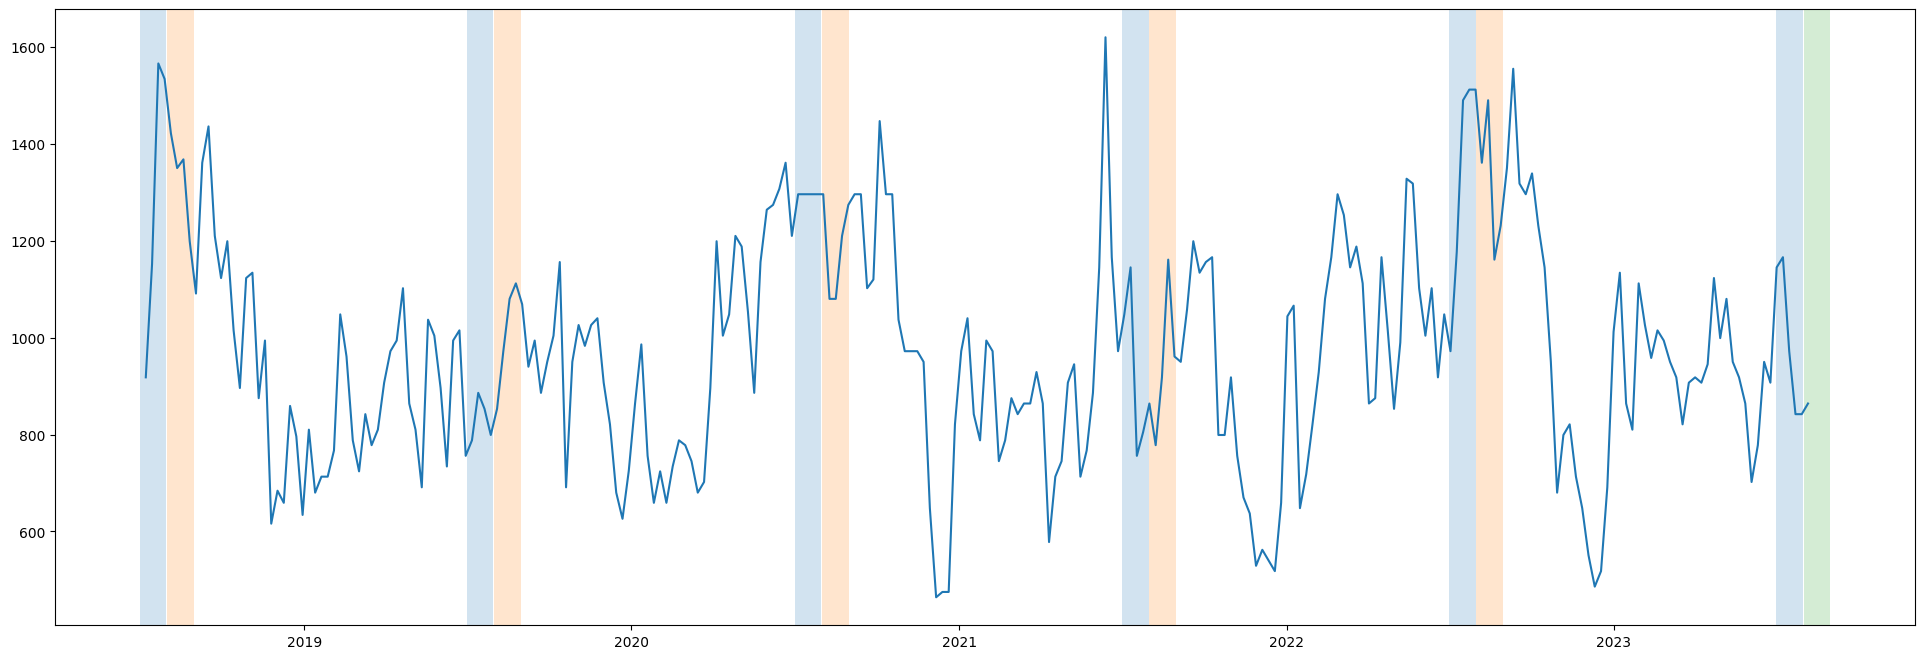

In [11]:
# だいこん: 価格推移をプロット
plt.figure(figsize=(24, 8))
plt.plot(daikon)
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.show()

In [12]:
# だいこん: ハイパーパラメータ探索 (周期：52週＝12カ月)
param_daikon = selectparameter(daikon, 52)
param_daikon

[(1, 1, 1), (0, 1, 1, 52), 2801.698044028823]

In [13]:
# だいこん: モデル構築 (SARIMA)
SARIMA_daikon = sm.tsa.statespace.SARIMAX(daikon, order=(1,1,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_daikon.bic

2801.698044028823

In [14]:
# だいこん: 予測値をプロット
pred_daikon = pd.DataFrame(round(SARIMA_daikon.predict("2018-07-08", "2024-08-30"), 1))
pred_daikon = pred_daikon.rename(columns={'predicted_mean':'mode_price'})
pred_daikon

,mode_price
2018-07-08,0.0
2018-07-15,914.9
...,...
2024-08-25,1008.7
2024-09-01,1065.2


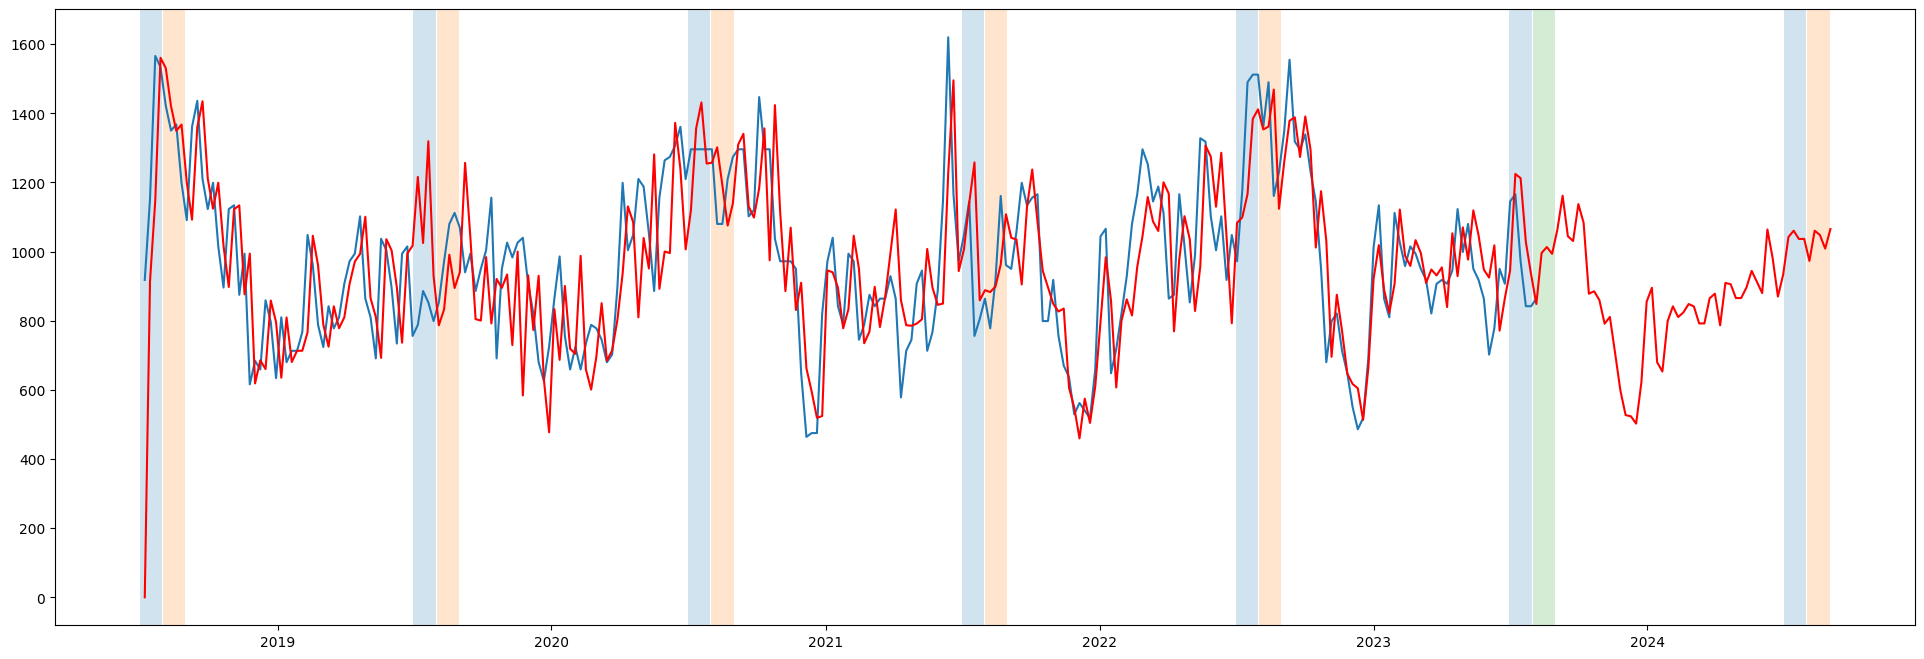

In [15]:
plt.figure(figsize=(24, 8))
plt.plot(daikon)
plt.plot(pred_daikon, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

In [16]:
# だいこん: Submitデータを作成
pred_daikon = pred_daikon.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_daikon = round(pred_daikon.interpolate(), 1)
pred_daikon = pred_daikon.reset_index()
pred_daikon.insert(0, "kind", "だいこん")
pred_daikon = pred_daikon.rename(columns={'index':'date'})
pred_daikon

,kind,date,mode_price
0,だいこん,2023-07-30,934.0
1,だいこん,2023-07-31,921.8
...,...,...,...
34,だいこん,2023-09-02,1053.3
35,だいこん,2023-09-03,1063.3


In [17]:
sub_daikon = sub[sub.kind == 'だいこん']
sub_daikon['date'] = pd.to_datetime(sub['date'], format='%Y%m%d')
sub_daikon = sub_daikon.drop('mode_price', axis=1)
sub_daikon

,kind,date
0,だいこん,2023-08-01
1,だいこん,2023-08-03
...,...,...
19,だいこん,2023-08-29
20,だいこん,2023-08-31


In [18]:
sub_daikon = pd.merge(sub_daikon, pred_daikon, on=['kind', 'date'], how="left")
sub_daikon["date"] = sub_daikon["date"].dt.strftime('%Y%m%d').astype(int)
sub_daikon

,kind,date,mode_price
0,だいこん,20230801,909.5
1,だいこん,20230803,885.1
...,...,...,...
19,だいこん,20230829,1013.5
20,だいこん,20230831,1033.4


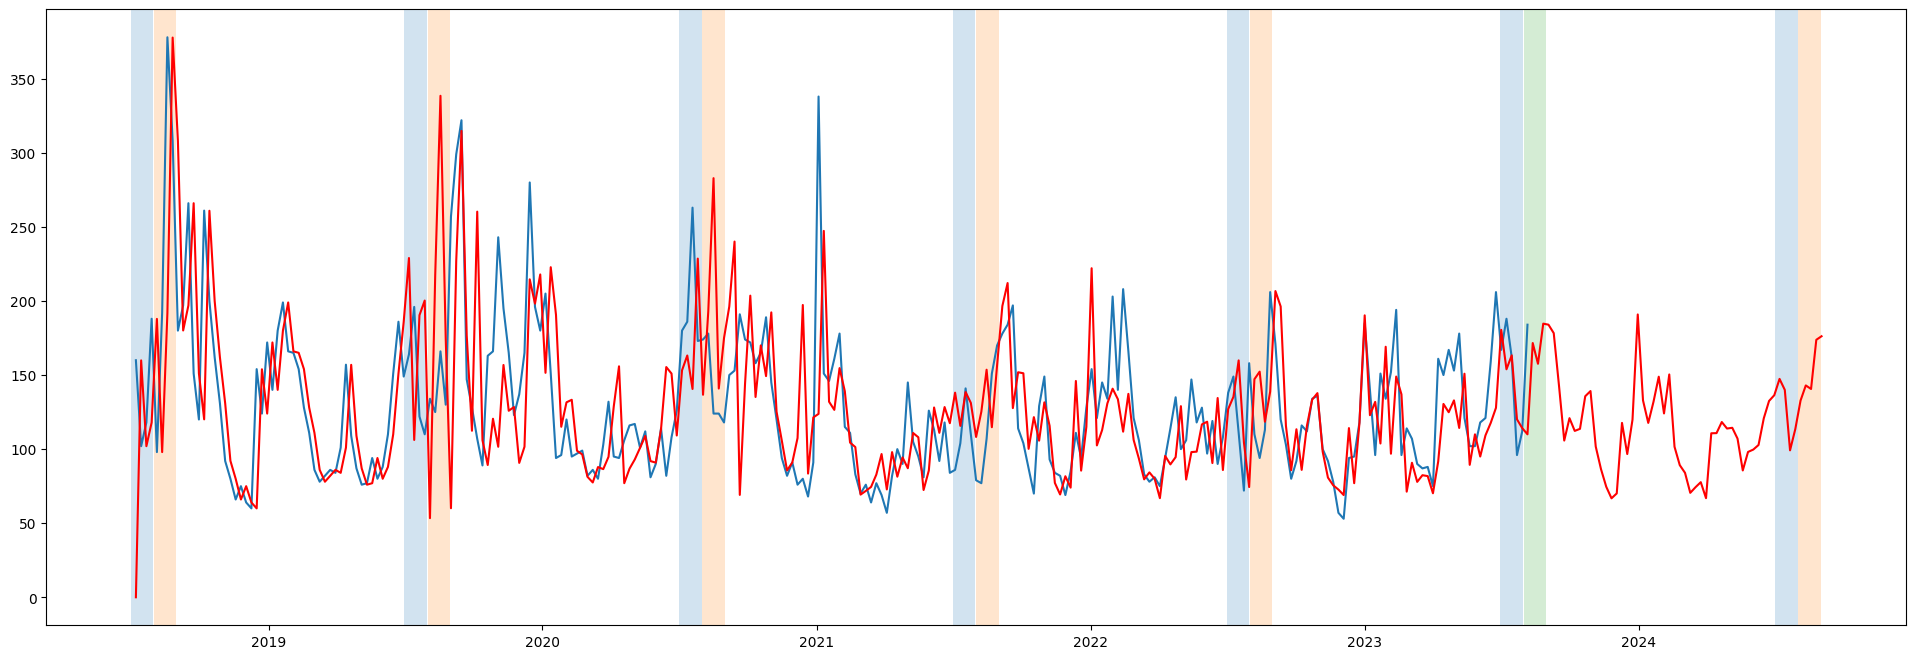

,kind,date,mode_price
0,こまつな,20230801,113.0
1,こまつな,20230803,111.8
...,...,...,...
19,こまつな,20230829,184.5
20,こまつな,20230831,184.3


In [19]:
# こまつな
komatsuna = train[train.kind == 'こまつな']
komatsuna.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
komatsuna = round(komatsuna.resample(rule="W").mean())

# モデル構築
# selectparameter(komatsuna, 52)
SARIMA_komatsuna = sm.tsa.statespace.SARIMAX(komatsuna, order=(1,1,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_komatsuna.bic

# 予測値をプロット
pred_komatsuna = pd.DataFrame(round(SARIMA_komatsuna.predict("2018-07-08", "2024-08-30"), 1))
pred_komatsuna = pred_komatsuna.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(komatsuna)
plt.plot(pred_komatsuna, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_komatsuna = pred_komatsuna.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_komatsuna = round(pred_komatsuna.interpolate(), 1)
pred_komatsuna = pred_komatsuna.reset_index()
pred_komatsuna.insert(0, "kind", "こまつな")
pred_komatsuna = pred_komatsuna.rename(columns={'index':'date'})
pred_komatsuna["date"] = pred_komatsuna["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_komatsuna = sub[sub.kind == 'こまつな']
sub_komatsuna = sub_komatsuna.drop('mode_price', axis=1)
sub_komatsuna = pd.merge(sub_komatsuna, pred_komatsuna, on=['kind', 'date'], how="left")
sub_komatsuna

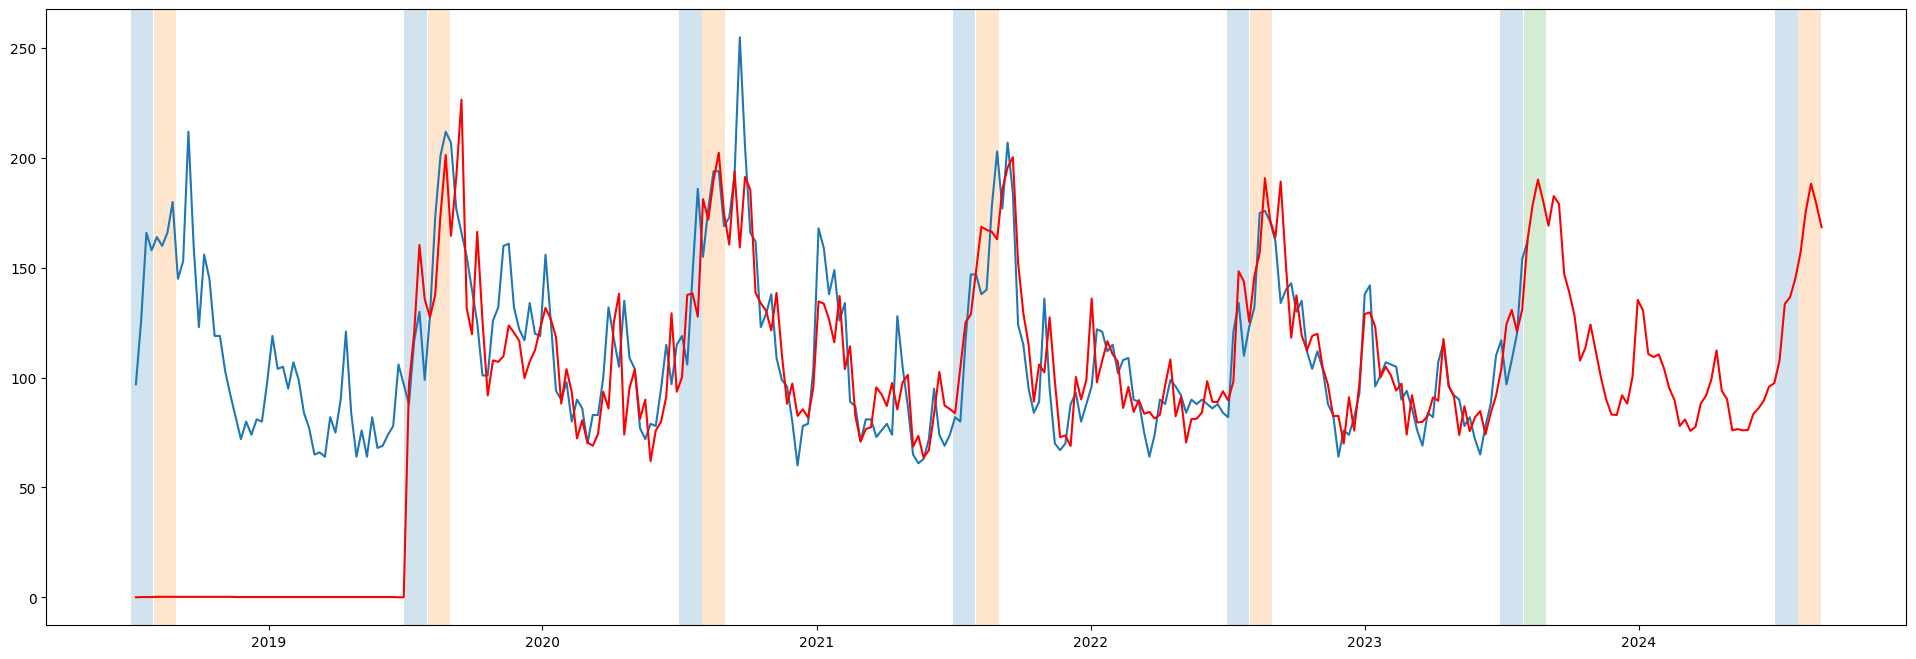

,kind,date,mode_price
0,ほうれんそう,20230801,140.1
1,ほうれんそう,20230803,149.0
...,...,...,...
19,ほうれんそう,20230829,177.1
20,ほうれんそう,20230831,174.0


In [20]:
# ほうれんそう
hourensou = train[train.kind == 'ほうれんそう']
hourensou.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
hourensou = round(hourensou.resample(rule="W").mean())

# モデル構築
# selectparameter(hourensou, 52)
SARIMA_hourensou = sm.tsa.statespace.SARIMAX(hourensou, order=(1,0,0), seasonal_order=(0,1,1,52)).fit()
SARIMA_hourensou.bic

# 予測値をプロット
pred_hourensou = pd.DataFrame(round(SARIMA_hourensou.predict("2018-07-08", "2024-08-30"), 1))
pred_hourensou = pred_hourensou.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(hourensou)
plt.plot(pred_hourensou, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_hourensou = pred_hourensou.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_hourensou = round(pred_hourensou.interpolate(), 1)
pred_hourensou = pred_hourensou.reset_index()
pred_hourensou.insert(0, "kind", "ほうれんそう")
pred_hourensou = pred_hourensou.rename(columns={'index':'date'})
pred_hourensou["date"] = pred_hourensou["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_hourensou = sub[sub.kind == 'ほうれんそう']
sub_hourensou = sub_hourensou.drop('mode_price', axis=1)
sub_hourensou = pd.merge(sub_hourensou, pred_hourensou, on=['kind', 'date'], how="left")
sub_hourensou

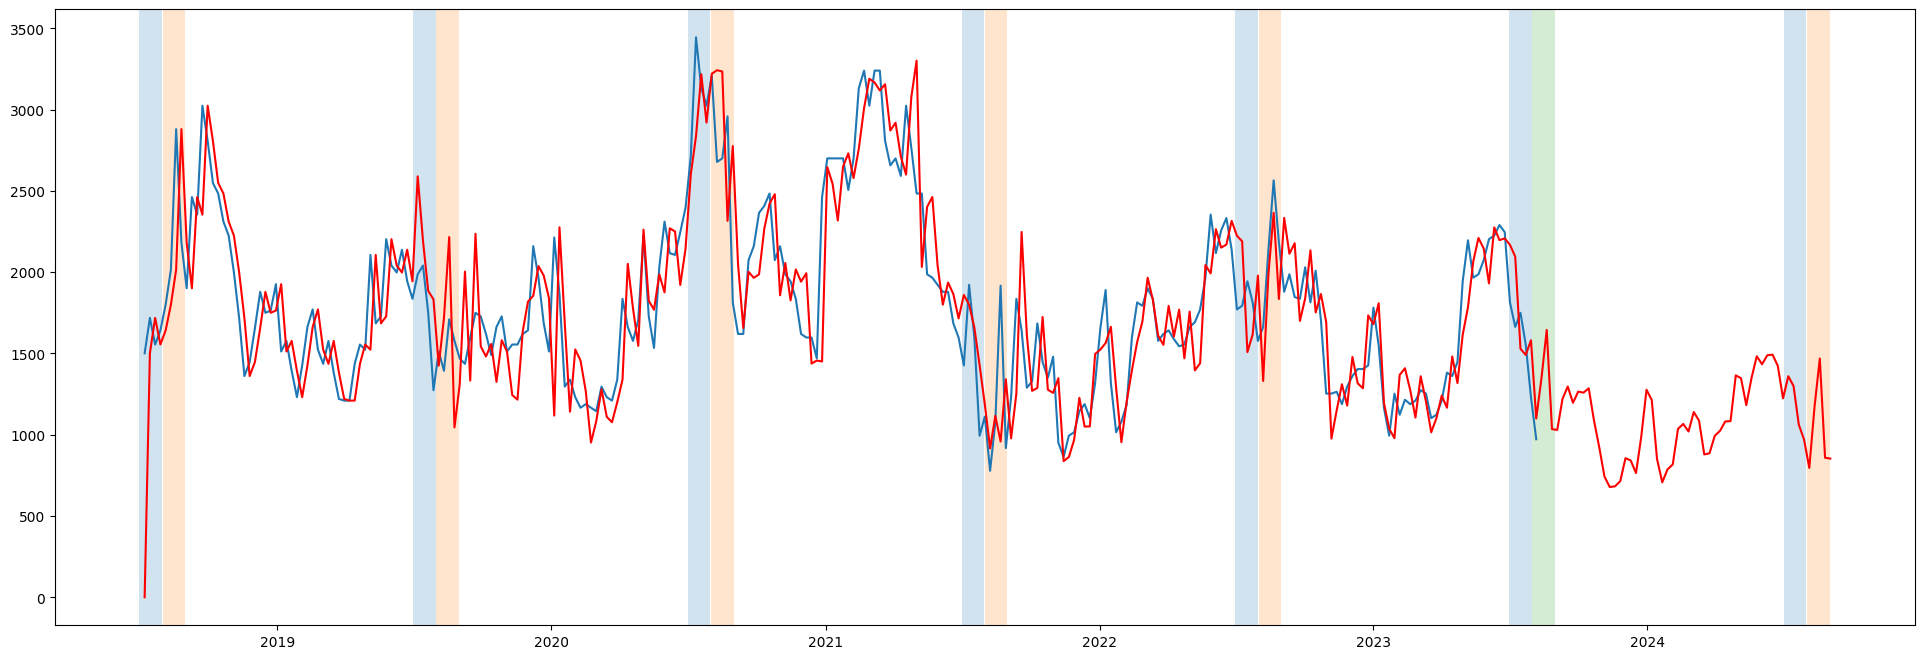

,kind,date,mode_price
0,ねぎ,20230801,1443.4
1,ねぎ,20230803,1305.8
...,...,...,...
19,ねぎ,20230829,1033.1
20,ねぎ,20230831,1031.7


In [21]:
# ねぎ
negi = train[train.kind == 'ねぎ']
negi.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
negi = round(negi.resample(rule="W").mean())

# モデル構築
# selectparameter(negi, 52)
SARIMA_negi = sm.tsa.statespace.SARIMAX(negi, order=(0,1,0), seasonal_order=(0,1,1,52)).fit()
SARIMA_negi.bic

# 予測値をプロット
pred_negi = pd.DataFrame(round(SARIMA_negi.predict("2018-07-08", "2024-08-30"), 1))
pred_negi = pred_negi.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(negi)
plt.plot(pred_negi, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_negi = pred_negi.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_negi = round(pred_negi.interpolate(), 1)
pred_negi = pred_negi.reset_index()
pred_negi.insert(0, "kind", "ねぎ")
pred_negi = pred_negi.rename(columns={'index':'date'})
pred_negi["date"] = pred_negi["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_negi = sub[sub.kind == 'ねぎ']
sub_negi = sub_negi.drop('mode_price', axis=1)
sub_negi = pd.merge(sub_negi, pred_negi, on=['kind', 'date'], how="left")
sub_negi

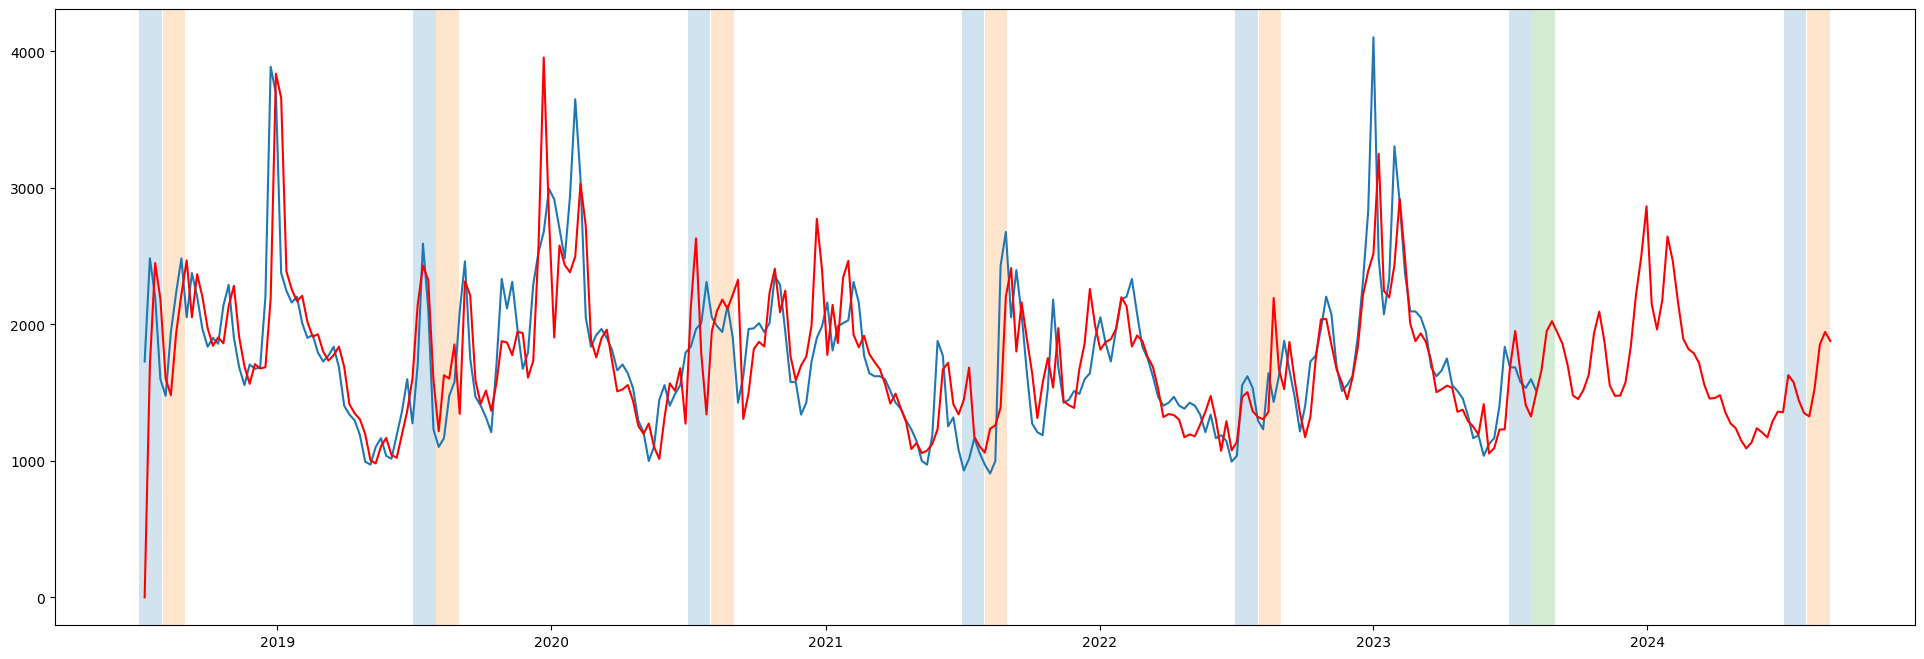

,kind,date,mode_price
0,きゅうり,20230801,1373.8
1,きゅうり,20230803,1423.1
...,...,...,...
19,きゅうり,20230829,1999.7
20,きゅうり,20230831,1976.4


In [22]:
# きゅうり
kyuri = train[train.kind == 'きゅうり']
kyuri.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
kyuri = round(kyuri.resample(rule="W").mean())

# モデル構築
# selectparameter(kyuri, 52)
SARIMA_kyuri = sm.tsa.statespace.SARIMAX(kyuri, order=(1,1,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_kyuri.bic

# 予測値をプロット
pred_kyuri = pd.DataFrame(round(SARIMA_kyuri.predict("2018-07-08", "2024-08-30"), 1))
pred_kyuri = pred_kyuri.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(kyuri)
plt.plot(pred_kyuri, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_kyuri = pred_kyuri.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_kyuri = round(pred_kyuri.interpolate(), 1)
pred_kyuri = pred_kyuri.reset_index()
pred_kyuri.insert(0, "kind", "きゅうり")
pred_kyuri = pred_kyuri.rename(columns={'index':'date'})
pred_kyuri["date"] = pred_kyuri["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_kyuri = sub[sub.kind == 'きゅうり']
sub_kyuri = sub_kyuri.drop('mode_price', axis=1)
sub_kyuri = pd.merge(sub_kyuri, pred_kyuri, on=['kind', 'date'], how="left")
sub_kyuri

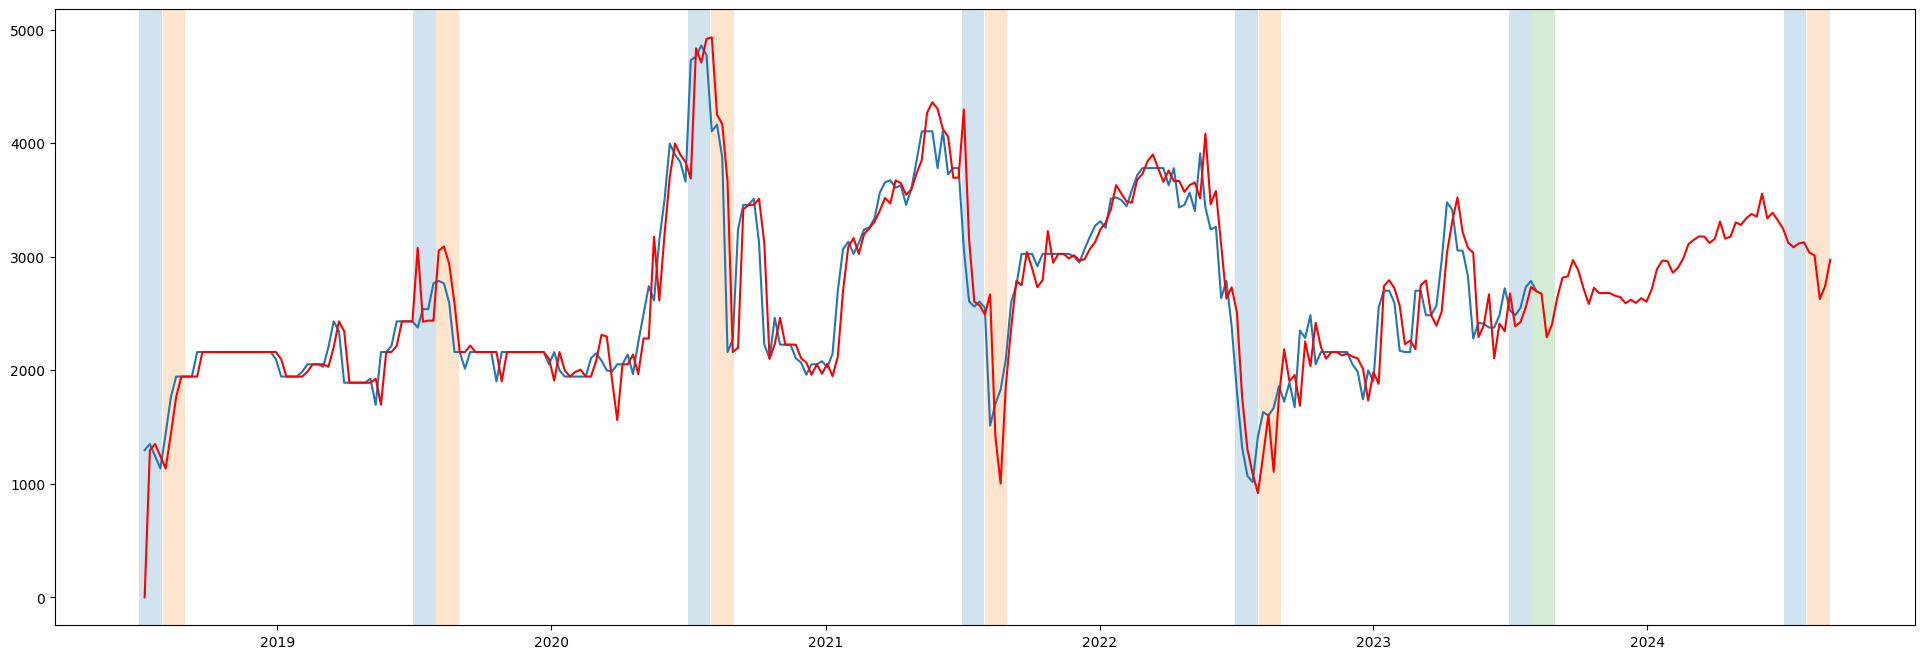

,kind,date,mode_price
0,じゃがいも,20230801,2721.9
1,じゃがいも,20230803,2711.3
...,...,...,...
19,じゃがいも,20230829,2469.7
20,じゃがいも,20230831,2536.9


In [23]:
# じゃがいも
zyagaimo = train[train.kind == 'じゃがいも']
zyagaimo.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
zyagaimo = round(zyagaimo.resample(rule="W").mean())

# モデル構築
# selectparameter(zyagaimo, 52)
SARIMA_zyagaimo = sm.tsa.statespace.SARIMAX(zyagaimo, order=(0,1,0), seasonal_order=(0,1,1,52)).fit()
SARIMA_zyagaimo.bic

# 予測値をプロット
pred_zyagaimo = pd.DataFrame(round(SARIMA_zyagaimo.predict("2018-07-08", "2024-08-30"), 1))
pred_zyagaimo = pred_zyagaimo.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(zyagaimo)
plt.plot(pred_zyagaimo, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_zyagaimo = pred_zyagaimo.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_zyagaimo = round(pred_zyagaimo.interpolate(), 1)
pred_zyagaimo = pred_zyagaimo.reset_index()
pred_zyagaimo.insert(0, "kind", "じゃがいも")
pred_zyagaimo = pred_zyagaimo.rename(columns={'index':'date'})
pred_zyagaimo["date"] = pred_zyagaimo["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_zyagaimo = sub[sub.kind == 'じゃがいも']
sub_zyagaimo = sub_zyagaimo.drop('mode_price', axis=1)
sub_zyagaimo = pd.merge(sub_zyagaimo, pred_zyagaimo, on=['kind', 'date'], how="left")
sub_zyagaimo

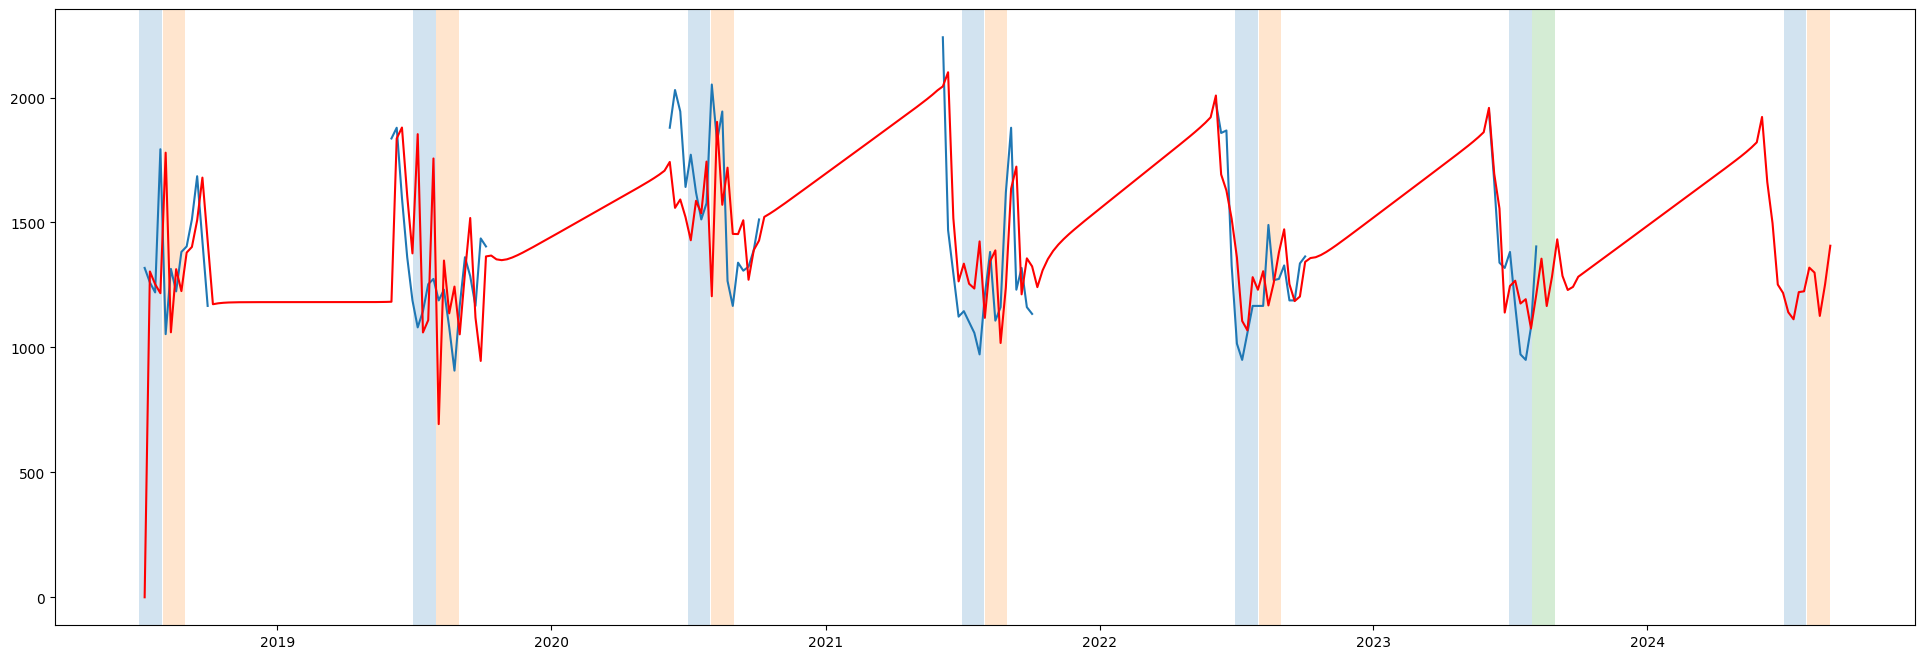

,kind,date,mode_price
0,とうもろこし,20230801,1114.4
1,とうもろこし,20230803,1152.7
...,...,...,...
19,とうもろこし,20230829,1325.3
20,とうもろこし,20230831,1368.1


In [24]:
# とうもろこし
toumorokosi = train[train.kind == 'とうもろこし']
toumorokosi.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
toumorokosi = round(toumorokosi.resample(rule="W").mean())

# モデル構築
# selectparameter(toumorokosi, 52)
SARIMA_toumorokosi = sm.tsa.statespace.SARIMAX(toumorokosi, order=(1,1,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_toumorokosi.bic

# 予測値をプロット
pred_toumorokosi = pd.DataFrame(round(SARIMA_toumorokosi.predict("2018-07-08", "2024-08-30"), 1))
pred_toumorokosi = pred_toumorokosi.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(toumorokosi)
plt.plot(pred_toumorokosi, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_toumorokosi = pred_toumorokosi.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_toumorokosi = round(pred_toumorokosi.interpolate(), 1)
pred_toumorokosi = pred_toumorokosi.reset_index()
pred_toumorokosi.insert(0, "kind", "とうもろこし")
pred_toumorokosi = pred_toumorokosi.rename(columns={'index':'date'})
pred_toumorokosi["date"] = pred_toumorokosi["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_toumorokosi = sub[sub.kind == 'とうもろこし']
sub_toumorokosi = sub_toumorokosi.drop('mode_price', axis=1)
sub_toumorokosi = pd.merge(sub_toumorokosi, pred_toumorokosi, on=['kind', 'date'], how="left")
sub_toumorokosi

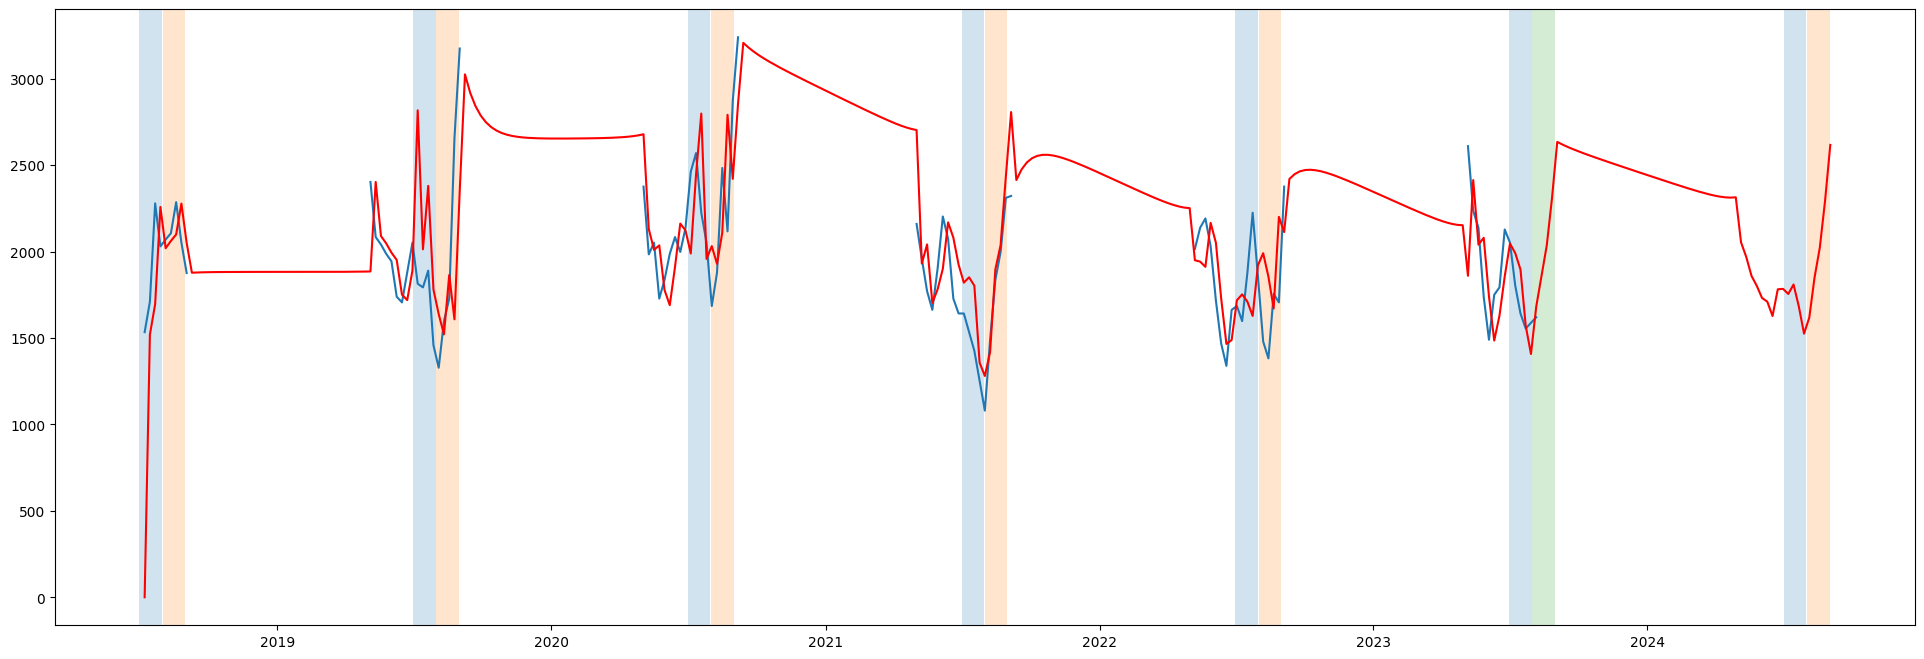

,kind,date,mode_price
0,いんげん,20230801,1485.9
1,いんげん,20230803,1564.2
...,...,...,...
19,いんげん,20230829,2401.5
20,いんげん,20230831,2494.8


In [25]:
# いんげん
ingen = train[train.kind == 'いんげん']
ingen.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
ingen = round(ingen.resample(rule="W").mean())

# モデル構築
# selectparameter(ingen, 52)
SARIMA_ingen = sm.tsa.statespace.SARIMAX(ingen, order=(1,1,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_ingen.bic

# 予測値をプロット
pred_ingen = pd.DataFrame(round(SARIMA_ingen.predict("2018-07-08", "2024-08-30"), 1))
pred_ingen = pred_ingen.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))

plt.plot(ingen)
plt.plot(pred_ingen, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_ingen = pred_ingen.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_ingen = round(pred_ingen.interpolate(), 1)
pred_ingen = pred_ingen.reset_index()
pred_ingen.insert(0, "kind", "いんげん")
pred_ingen = pred_ingen.rename(columns={'index':'date'})
pred_ingen["date"] = pred_ingen["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_ingen = sub[sub.kind == 'いんげん']
sub_ingen = sub_ingen.drop('mode_price', axis=1)
sub_ingen = pd.merge(sub_ingen, pred_ingen, on=['kind', 'date'], how="left")
sub_ingen

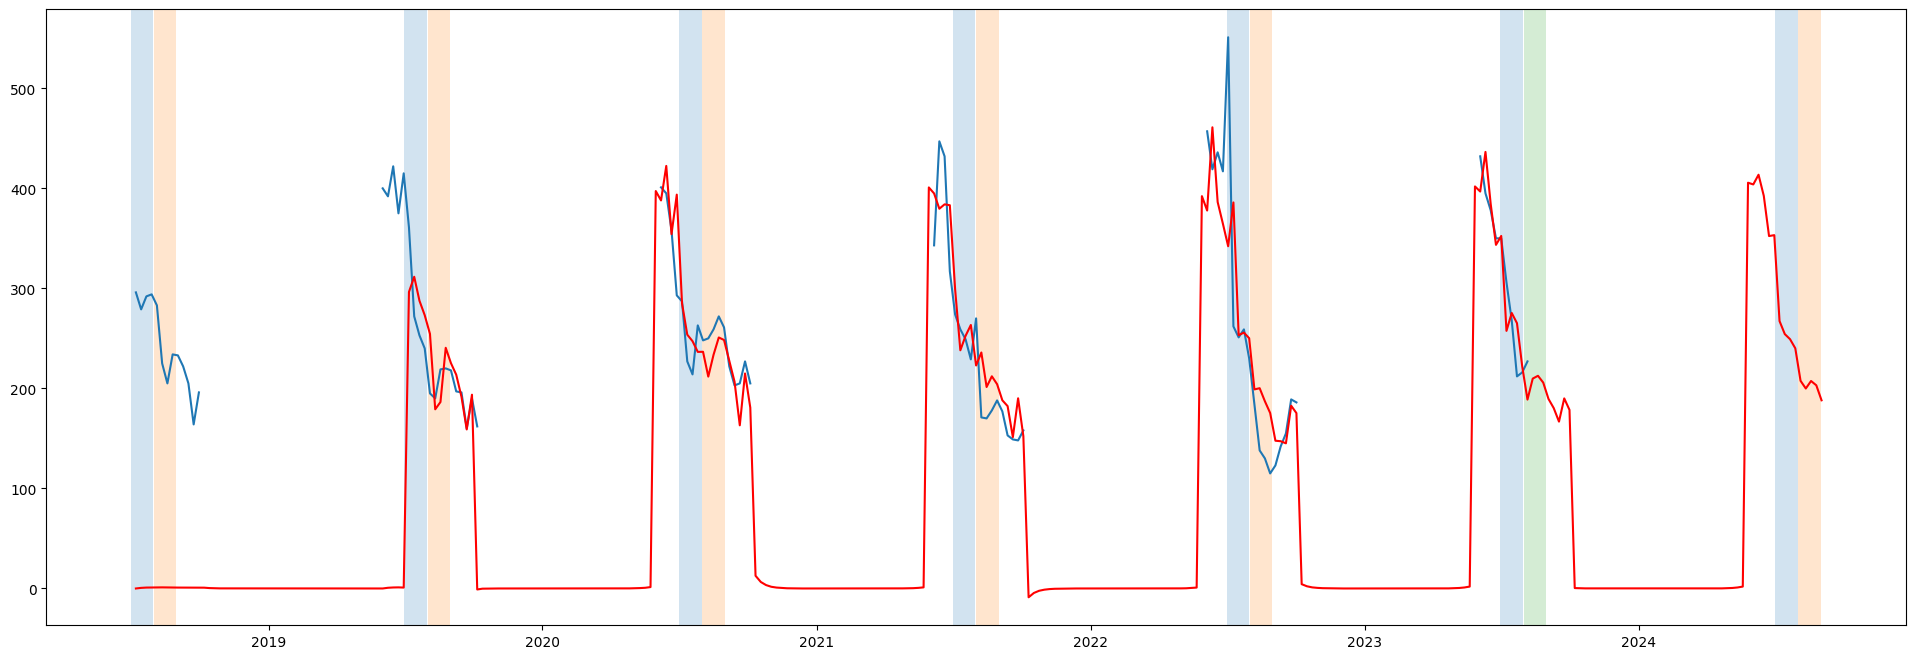

,kind,date,mode_price
0,えだまめ,20230801,212.4
1,えだまめ,20230803,203.0
...,...,...,...
19,えだまめ,20230829,201.1
20,えだまめ,20230831,196.5


In [26]:
# えだまめ
edamame = train[train.kind == 'えだまめ']
edamame.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
edamame = round(edamame.resample(rule="W").mean())

# モデル構築
# selectparameter(edamame, 52)
SARIMA_edamame = sm.tsa.statespace.SARIMAX(edamame, order=(1,0,0), seasonal_order=(0,1,1,52)).fit()
SARIMA_edamame.bic

# 予測値をプロット
pred_edamame = pd.DataFrame(round(SARIMA_edamame.predict("2018-07-08", "2024-08-30"), 1))
pred_edamame = pred_edamame.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(edamame)
plt.plot(pred_edamame, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_edamame = pred_edamame.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_edamame = round(pred_edamame.interpolate(), 1)
pred_edamame = pred_edamame.reset_index()
pred_edamame.insert(0, "kind", "えだまめ")
pred_edamame = pred_edamame.rename(columns={'index':'date'})
pred_edamame["date"] = pred_edamame["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_edamame = sub[sub.kind == 'えだまめ']
sub_edamame = sub_edamame.drop('mode_price', axis=1)
sub_edamame = pd.merge(sub_edamame, pred_edamame, on=['kind', 'date'], how="left")
sub_edamame

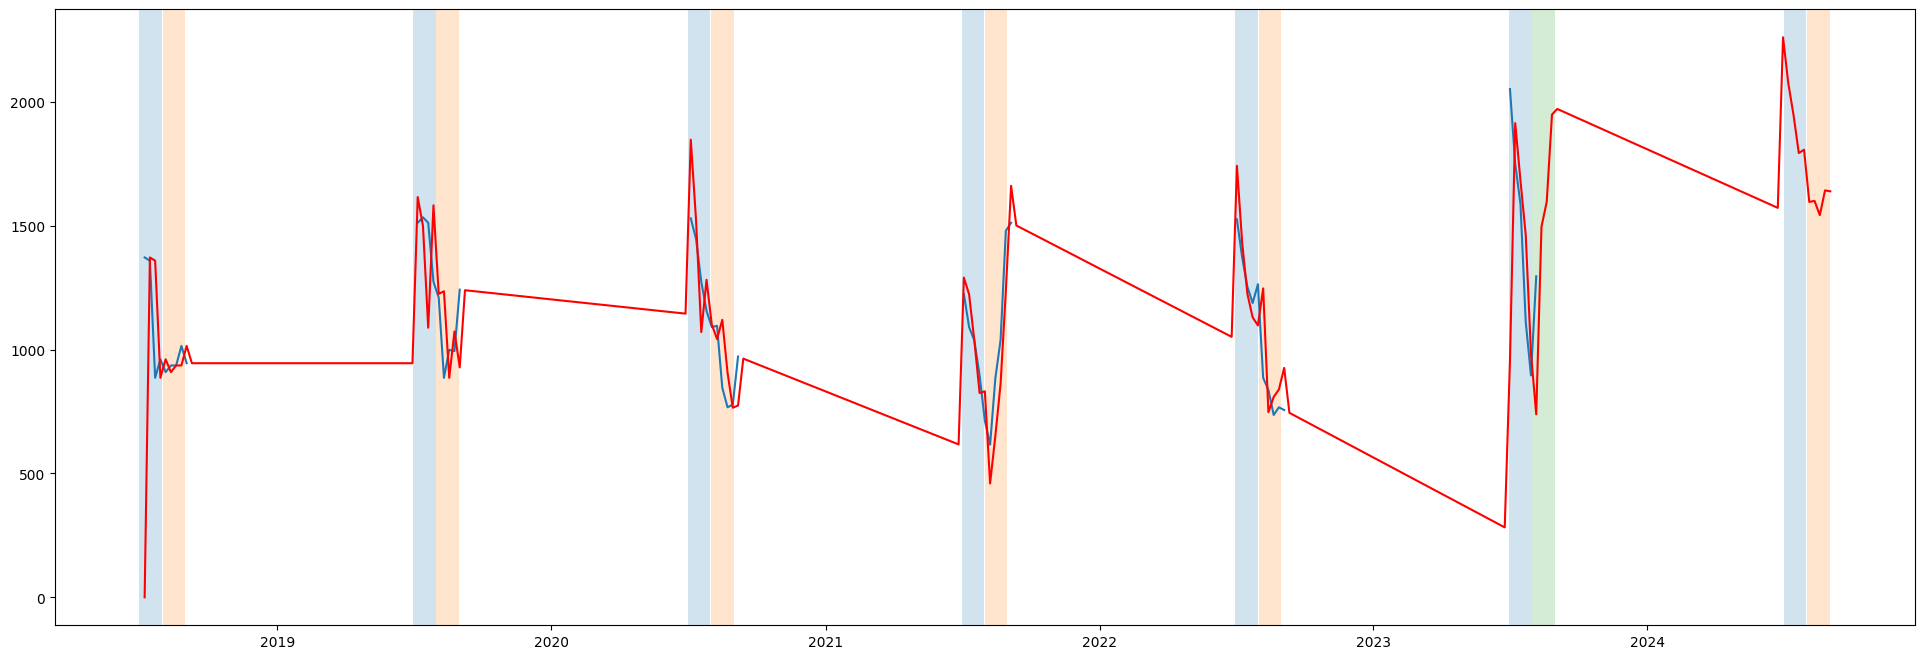

,kind,date,mode_price
0,レイシにがうり,20230801,914.3
1,レイシにがうり,20230803,844.1
...,...,...,...
19,レイシにがうり,20230829,1955.4
20,レイシにがうり,20230831,1961.9


In [27]:
# レイシにがうり
reisinigauri = train[train.kind == 'レイシにがうり']
reisinigauri.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
reisinigauri = round(reisinigauri.resample(rule="W").mean())

# モデル構築
# selectparameter(reisinigauri, 52)
SARIMA_reisinigauri = sm.tsa.statespace.SARIMAX(reisinigauri, order=(0,1,0), seasonal_order=(1,1,0,52)).fit()
SARIMA_reisinigauri.bic

# 予測値をプロット
pred_reisinigauri = pd.DataFrame(round(SARIMA_reisinigauri.predict("2018-07-08", "2024-08-30"), 1))
pred_reisinigauri = pred_reisinigauri.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(reisinigauri)
plt.plot(pred_reisinigauri, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_reisinigauri = pred_reisinigauri.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_reisinigauri = round(pred_reisinigauri.interpolate(), 1)
pred_reisinigauri = pred_reisinigauri.reset_index()
pred_reisinigauri.insert(0, "kind", "レイシにがうり")
pred_reisinigauri = pred_reisinigauri.rename(columns={'index':'date'})
pred_reisinigauri["date"] = pred_reisinigauri["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_reisinigauri = sub[sub.kind == 'レイシにがうり']
sub_reisinigauri = sub_reisinigauri.drop('mode_price', axis=1)
sub_reisinigauri = pd.merge(sub_reisinigauri, pred_reisinigauri, on=['kind', 'date'], how="left")
sub_reisinigauri

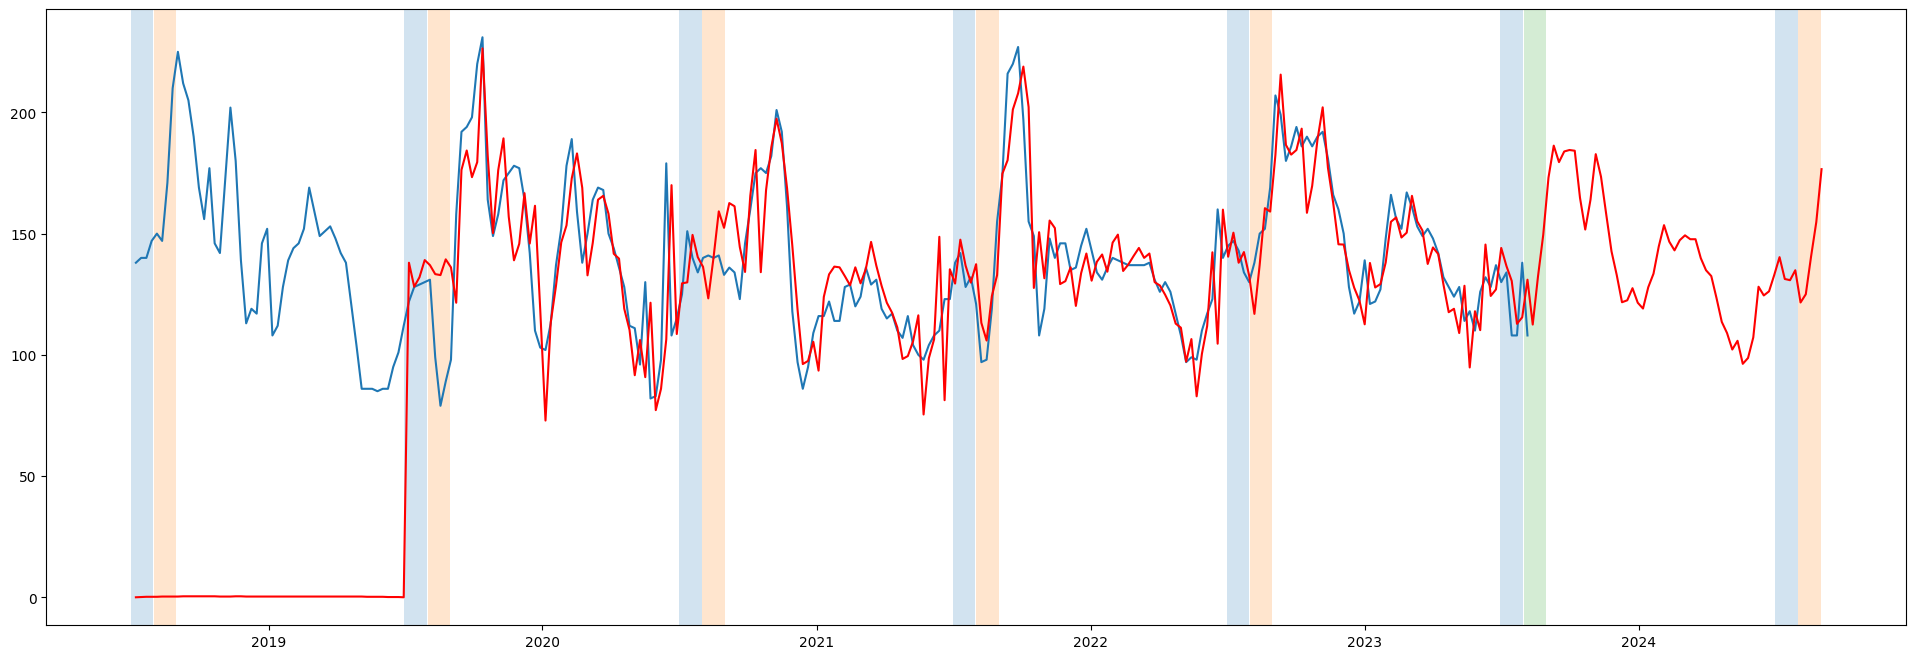

,kind,date,mode_price
0,ミニトマト,20230801,119.9
1,ミニトマト,20230803,124.4
...,...,...,...
19,ミニトマト,20230829,156.2
20,ミニトマト,20230831,163.0


In [28]:
# ミニトマト
minitomato = train[train.kind == 'ミニトマト']
minitomato.drop(["kind", "date", 'amount', 'area', "year", "weekno"], axis=1, inplace=True)
minitomato = round(minitomato.resample(rule="W").mean())

# モデル構築
# selectparameter(minitomato, 52)
SARIMA_minitomato = sm.tsa.statespace.SARIMAX(minitomato, order=(1,0,1), seasonal_order=(0,1,1,52)).fit()
SARIMA_minitomato.bic

# 予測値をプロット
pred_minitomato = pd.DataFrame(round(SARIMA_minitomato.predict("2018-07-08", "2024-08-30"), 1))
pred_minitomato = pred_minitomato.rename(columns={'predicted_mean':'mode_price'})
plt.figure(figsize=(24, 8))
plt.plot(minitomato)
plt.plot(pred_minitomato, color="r")
plt.axvspan('2018-07-01', '2018-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2018-08-01', '2018-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2019-07-01', '2019-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2019-08-01', '2019-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2020-07-01', '2020-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2020-08-01', '2020-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2021-07-01', '2021-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2021-08-01', '2021-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2022-07-01', '2022-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2022-08-01', '2022-08-31', facecolor='C1', alpha=0.2)
plt.axvspan('2023-07-01', '2023-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2023-08-01', '2023-08-31', facecolor='C2', alpha=0.2)
plt.axvspan('2024-07-01', '2024-07-31', facecolor='C0', alpha=0.2)
plt.axvspan('2024-08-01', '2024-08-31', facecolor='C1', alpha=0.2)
plt.show()

# 予測データを整形
pred_minitomato = pred_minitomato.reindex(pd.date_range(start='2023/7/30', end='2023/9/3'))
pred_minitomato = round(pred_minitomato.interpolate(), 1)
pred_minitomato = pred_minitomato.reset_index()
pred_minitomato.insert(0, "kind", "ミニトマト")
pred_minitomato = pred_minitomato.rename(columns={'index':'date'})
pred_minitomato["date"] = pred_minitomato["date"].dt.strftime('%Y%m%d').astype(int)

# Submitデータを作成
sub_minitomato = sub[sub.kind == 'ミニトマト']
sub_minitomato = sub_minitomato.drop('mode_price', axis=1)
sub_minitomato = pd.merge(sub_minitomato, pred_minitomato, on=['kind', 'date'], how="left")
sub_minitomato

In [29]:
# csvデータで保存
sub_all = pd.concat([sub_daikon, sub_komatsuna, sub_hourensou, sub_negi, sub_kyuri, sub_zyagaimo, sub_toumorokosi, sub_ingen, sub_edamame, sub_reisinigauri, sub_minitomato])
sub_all = sub_all.reset_index(drop=True)
sub_all.to_csv('/content/drive/MyDrive/submission.csv', index=False)
sub_all

,kind,date,mode_price
0,だいこん,20230801,909.5
1,だいこん,20230803,885.1
...,...,...,...
229,ミニトマト,20230829,156.2
230,ミニトマト,20230831,163.0
